<a href="https://colab.research.google.com/github/mathysgrapotte/deepexplain/blob/main/Revised_v3_04_shapley_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainable AI with SHAP (SHapley Additive exPlanations)**


- The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features. A player can be an individual feature value, e.g. for tabular data [Example 1]. A player can also be a group of feature values. For example to explain an image, pixels can be grouped to superpixels and the prediction distributed among them [Example 2][7].


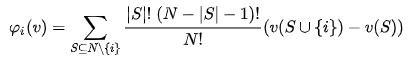

Shapley establishes the following four Axioms in order to achieve a fair contribution[19]:
* Axiom 1: Efficiency. The sum of the Shapley values of all agents equals the value of the total coalition.
* Axiom 2: Symmetry. All players have a fair chance to join the game. That’s why Table A above lists all the permutations of the players.


_If two players always give the same contribution, then they must receive the same payoff_



* Axiom 3: Dummy. If player i contributes nothing to any coalition S, then the contribution of Player i is zero, i.e. , φᵢ(v)=0. Obviously we need to set the boundary value.
* Axiom 4: Additivity. For any pair of games v, w: φ(v+w)=φ(v)+φ(w), where (v+w)(S)=v(S)+w(S) for all S. This property enables us to do the simple arithmetic summation.

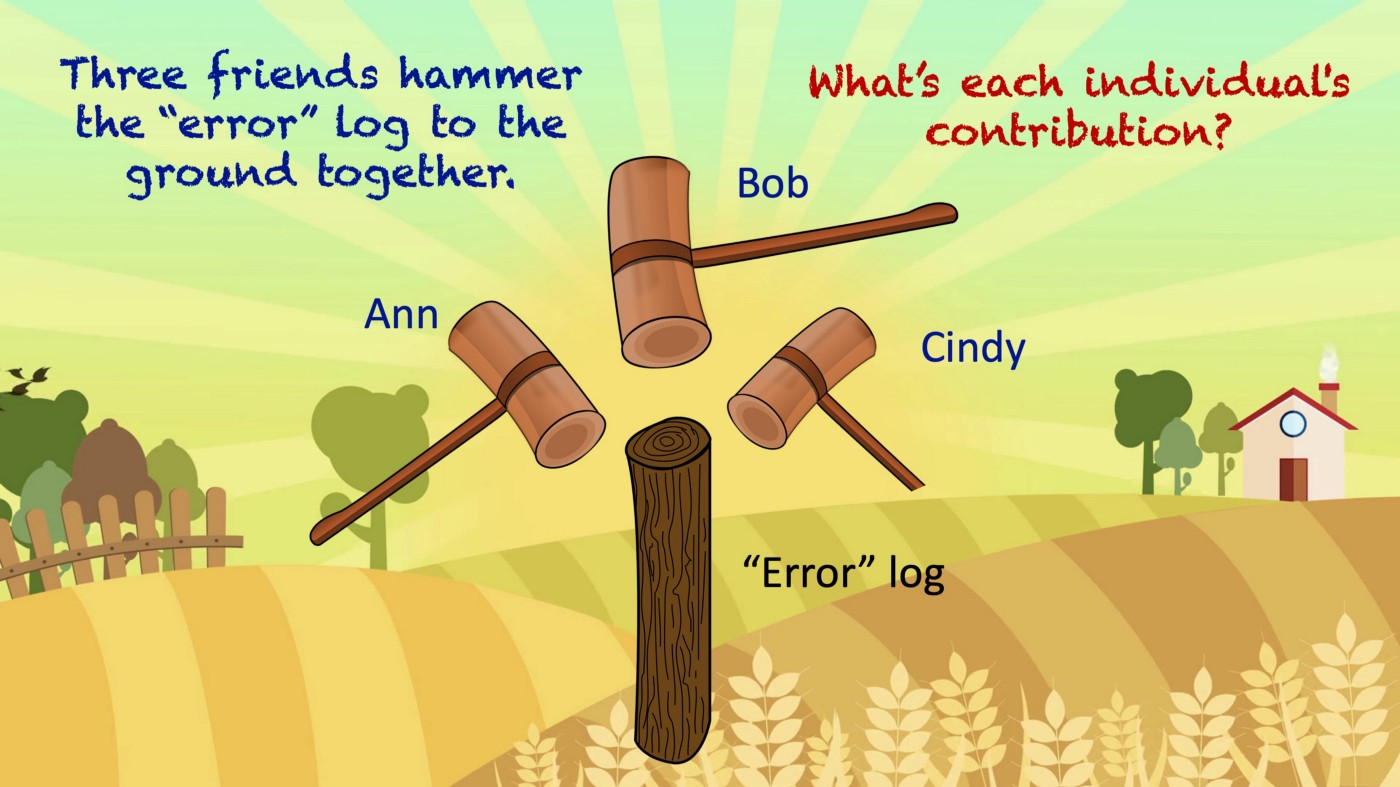

- This tutorial is designed to help build a basic understanding of how to compute and interpet Shapley-based explanations on deep learning model using the SHAP Python package.
 

#Pipeline of explainable tool SHAP
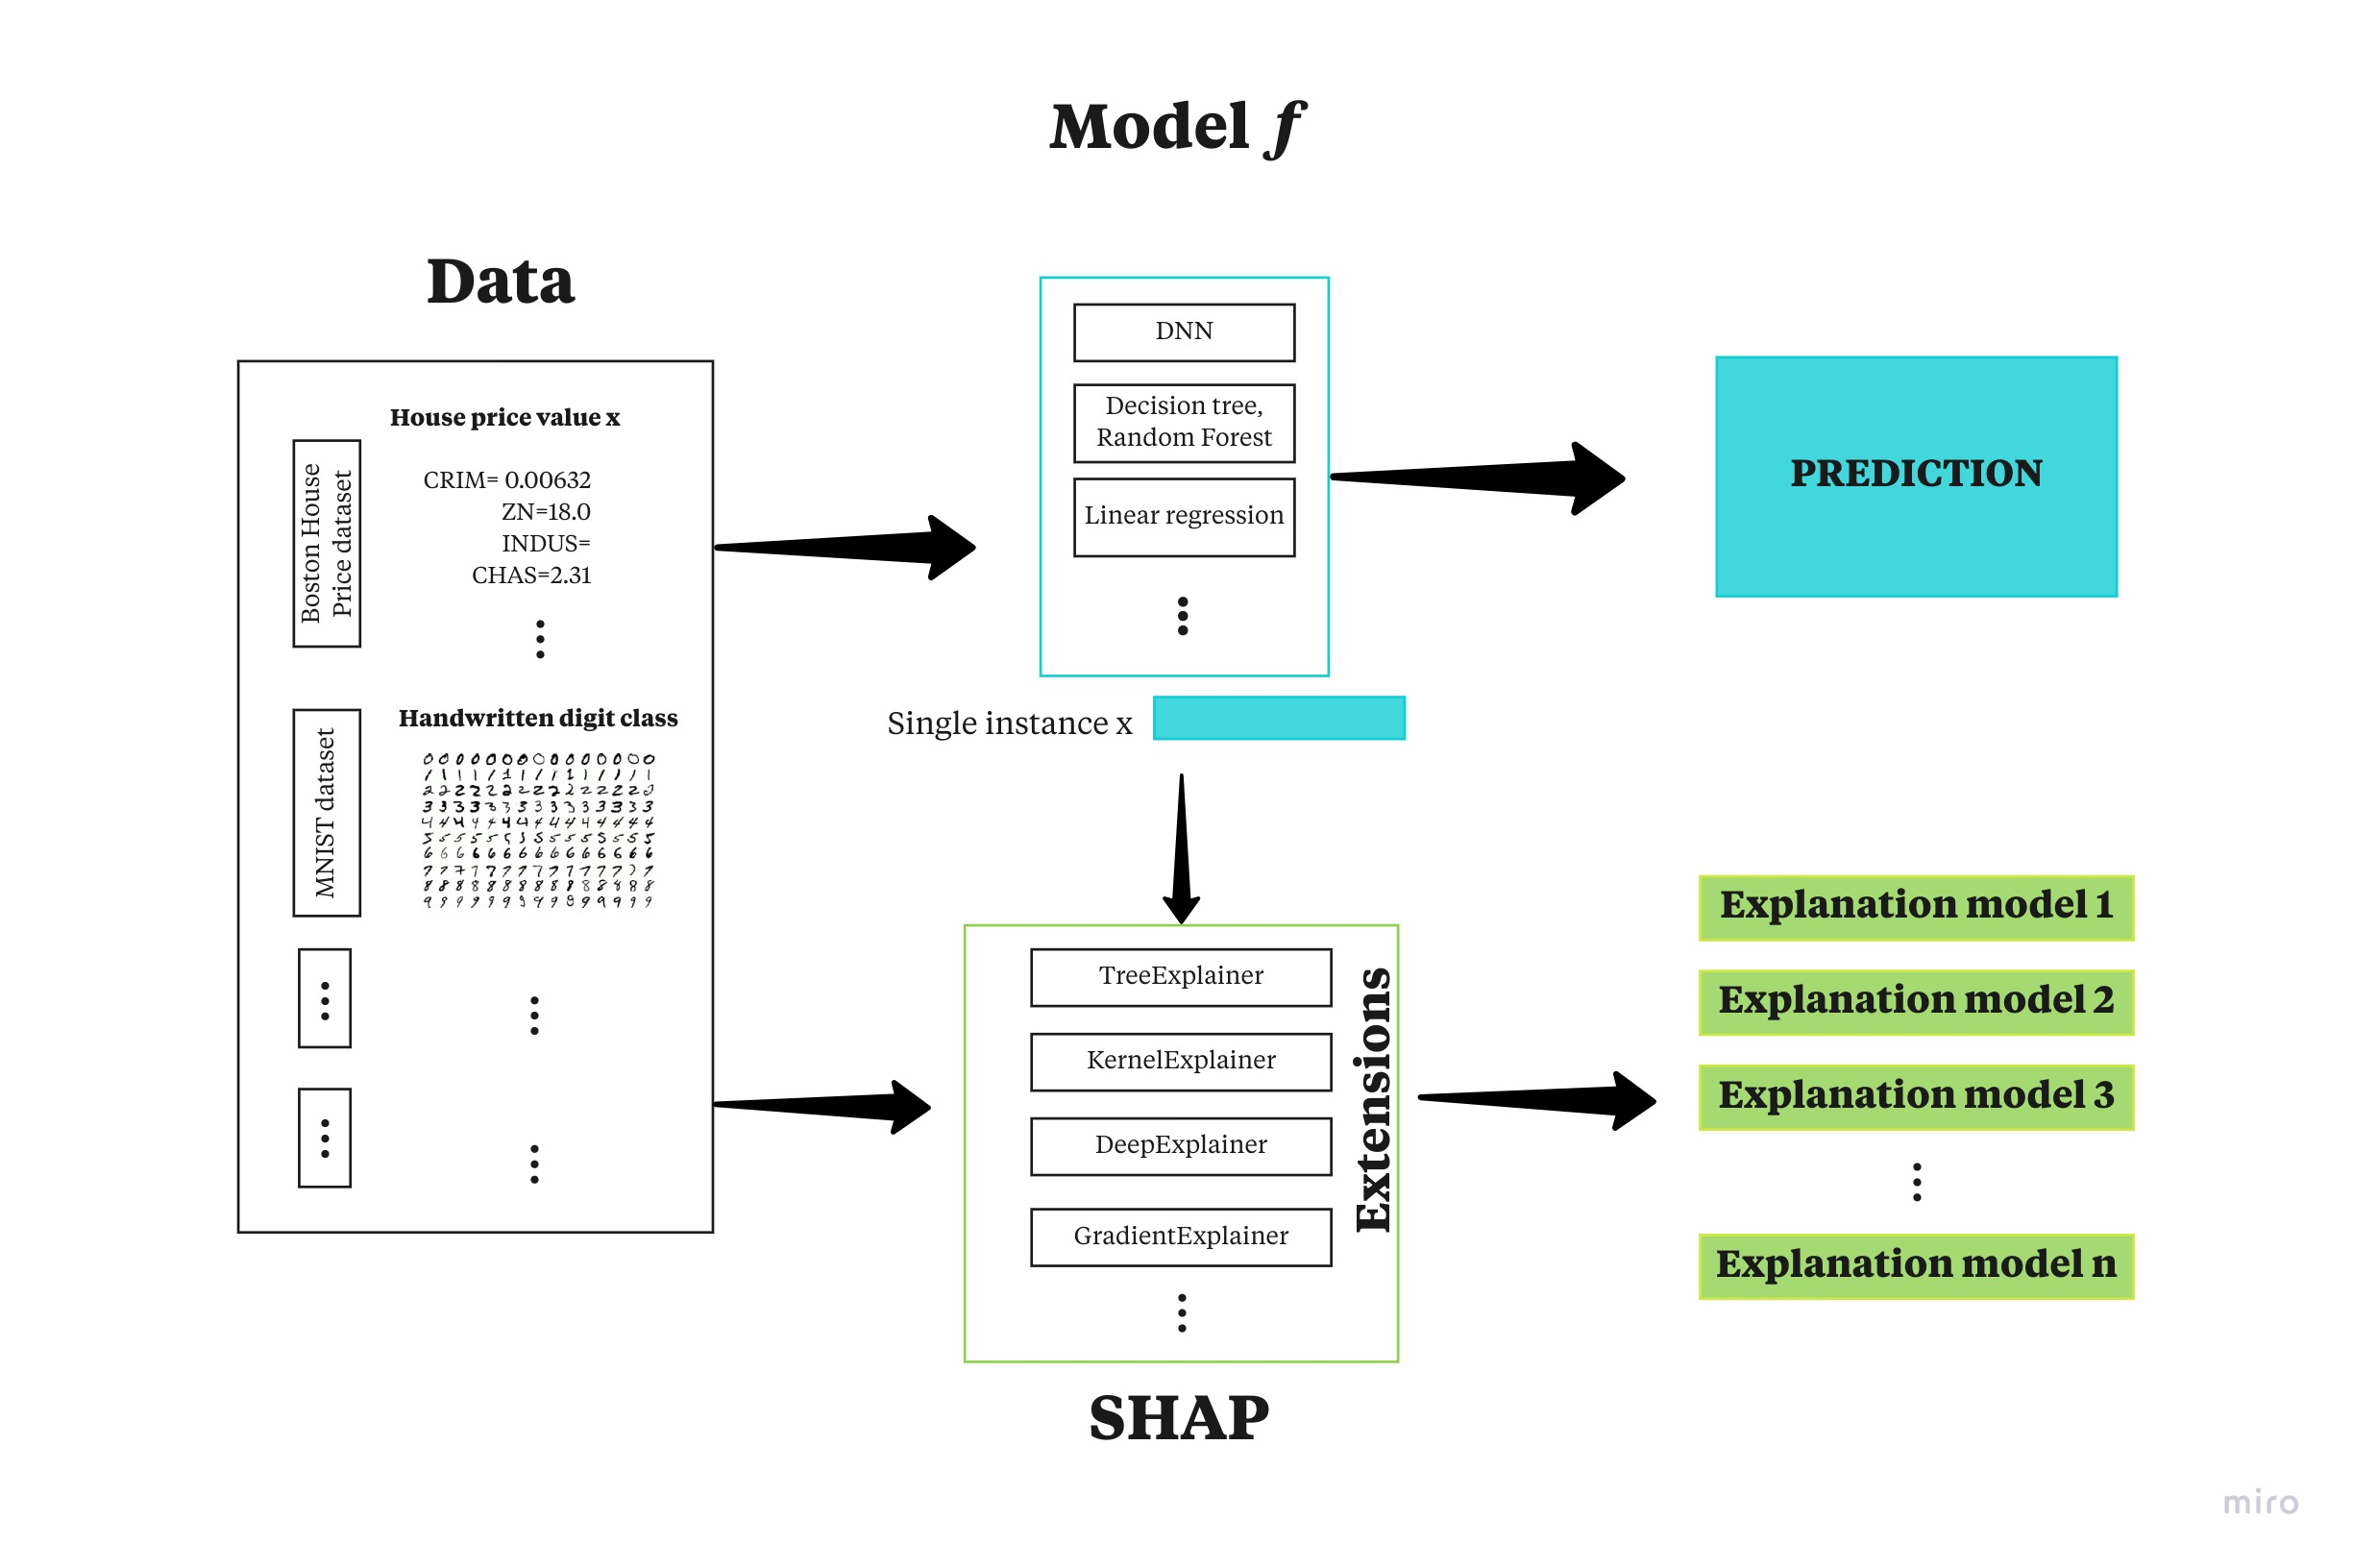

_What elements correstpond to players and how do we interpret contribution in the case for ML models? I know you mention something at the end of the paragraph but we need to be much more clear and do it in the beginning of the paragraph._

_Technical question: does it use the average of the feature you consider in the prediction to get coalition values or the average of the predictions?_

In the model agnostic explainer, SHAP leverages Shapley values in the below manner. To get the importance of feature X{i} [13]:

*  Get all subsets of features S that do not contain X{i}
*  Compute effect on our predictions of adding X{i} to all those subsets
*  Aggregate all contributions to compute the marginal contribution of the feature

Now, for these subsets, SHAP does not go on and retrain the model for each subset. Instead, for the removed or left out feature, it just replaces it with the average value of the feature and generates the predictions.

CORE *SHAP* EXTENSIONS [16]: 

*   TreeExplainer - high speed exact algorithm for tree ensembles
*   DeepExplainer - high speed approximation algorithm for chef values in deep learning models
*   GradientExplainer -combines ideas from Integrated Gradients, Shap and SmoothGrad into a single expected value equation 
*   KernelExplainer- uses specially-weighted local linear regression to estimate Shap values for any model



# Example 1 - Boston House Prices 
## About the Dataset
We will be working on a data set that comes from the real estate industry in Boston (US)[17]. This database contains 14 attributes. The target variable refers to the median value of owner-occupied homes in 1000 USD's.

* CRIM: per capita crime rate by town
* ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS: proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: nitric oxides concentration (parts per 10 million)
* RM: average number of rooms per dwelling
* AGE: proportion of owner-occupied units built prior to 1940
* DIS: weighted distances to five Boston employment centres
* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per 10,000 USD
* PTRATIO: pupil-teacher ratio by town
* B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT: lower status of the population (%)
* MEDV: Median value of owner-occupied homes in 1000 USD's (Target)


In [1]:
# setup
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import Sequential    
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#@title
def create_model(n_features):
        # define the model
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(n_features,)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    
    return model

def train(X_train,y_train,epochs):
    n_features = X_train.shape[1]
    model = create_model(n_features)
    # Compile the model:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = tf.metrics.mean_squared_error
       
    model.compile(optimizer=optimizer, loss=loss)
    # model training
    callbacks = [EarlyStopping(monitor='val_loss', mode='min',
                           patience=10,
                           restore_best_weights=True)]
    #model fit
    model.fit(X_train, y_train,
          shuffle=True,
          callbacks=callbacks,
          epochs=epochs, validation_split=0.2)
    
    return model



#Loading Data

In [45]:
def load_boston():
    
    '''
    load Boston housing dataset from the original CMU source - code used from official sklearn docs

    we have to make this workaround to ensure that we have the data on colab AND we do not get deprecation issues in the future 
    (Boston Housing is going to be deprecated due to ethical issues, see sklearn docs)
    
    '''
    columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT', 'PRICE']

    import pandas as pd  # doctest: +SKIP
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])

    _dat=[[float(val) for val in row[0].split()]+[float(val) for val in row[1].split()] for row in data]
    clean=pd.DataFrame(_dat)

    clean.columns=columns

    return clean


In [46]:
data=load_boston()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [48]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


# Data Preparation

In [49]:
# Here we will split data into X and y
X = data.drop('PRICE', axis=1)
y = data['PRICE']

In [50]:
# Use the function train_test_split( ) to split our data into two sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
print('Train data:', X_train.shape)
print('Test data:', X_test.shape)

Train data: (354, 13)
Test data: (152, 13)


In [52]:
def plot_model_hist(hist, feat='loss', figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.plot(hist.index, hist[f'{feat}'], label='train')
    plt.plot(hist.index, hist[f'val_{feat}'], label='valid')
    plt.xlabel('epoch')
    plt.ylabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [53]:
model=train(X_train, y_train, 50)

Epoch 1/50
9/9 [==============================] - 3s 29ms/step - loss: 51952.7266 - val_loss: 44535.8906
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 40649.2031 - val_loss: 34715.6758
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 31668.4355 - val_loss: 26776.1309
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 24250.4688 - val_loss: 20544.9082
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 18493.4453 - val_loss: 15616.4629
Epoch 6/50
9/9 [==============================] - 0s 9ms/step - loss: 13918.1182 - val_loss: 11687.6299
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 10306.7617 - val_loss: 8560.1748
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 7483.9302 - val_loss: 6112.1924
Epoch 9/50
9/9 [==============================] - 0s 9ms/step - loss: 5310.8447 - val_loss: 4302.9175
Epoch 10/50
9/9 [==============================] - 0s 7ms/step - los

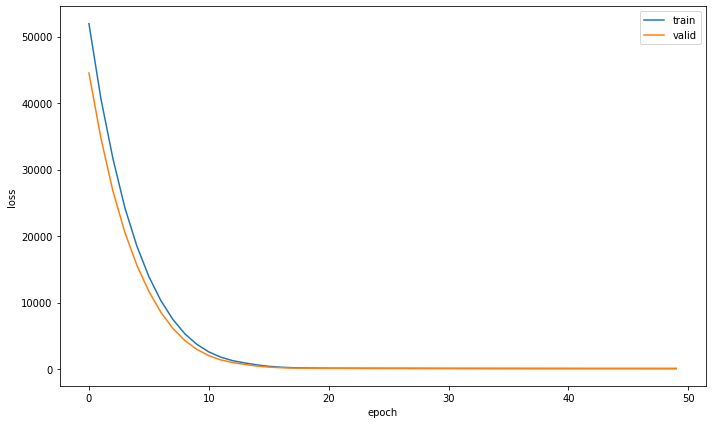

In [54]:
# Plot Loss as a Function of Number of Epoch
model_hist = pd.DataFrame(model.history.history)
plot_model_hist(model_hist)

In [55]:
print('MSE (train):', model.evaluate(X_train, y_train),
      '\nMSE (test):', model.evaluate(X_test, y_test))

5/5 [==============================] - 0s 3ms/step - loss: 69.9877
MSE (train): 83.15602111816406 
MSE (test): 69.98772430419922


_Pretty suspicious to overperform the train data on validation..._

_Also, added titles to graphs_

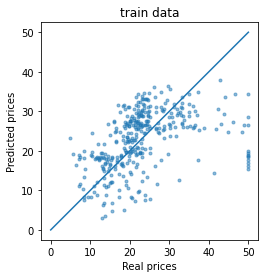

In [57]:
plt.scatter(y_train, model.predict(X_train), marker='.', alpha=0.5)
plt.plot([0,50],[0,50])
plt.title('train data')
plt.xlabel('Real prices')
plt.ylabel('Predicted prices')
plt.gca().set_aspect('equal')

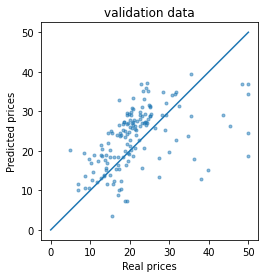

In [58]:
plt.scatter(y_test, model.predict(X_test), marker='.', alpha=0.5)
plt.plot([0,50],[0,50])
plt.title('validation data')
plt.xlabel('Real prices')
plt.ylabel('Predicted prices')
plt.gca().set_aspect('equal')

## Installation

SHAP can be installed from either PyPI or conda-forge:
##### pip install shap
##### or
##### conda install -c conda-forge shap

In [59]:
!pip install shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [60]:
import shap
shap.initjs()

We have trained machine learning model to predict house prices. For a certain house it will predict its  monetary value and you need to explain this prediction. Therefore, we are interested how much has each feature value contributed to the prediction compared to the average prediction.
Although, if model is a deep learning model (and you are working with sequential data), it is advisable to use DeepExplainer. In this example, we will showcase SHAP method applicable to any model- KernelExplainer

*   The Kernel Explainer builds a weighted linear regression by using your data, your predictions, and the function that predicts the predicted values
*   It computes the variable importance values based on the Shapley values from game theory, and the coefficients from a local linear regression

_You should go into more technical detail about KernelExplainer_

_Is SHAP invariant to rescaling the features?_




In [61]:
# Fix seed for reproducibility
np.random.seed(123)

# Summarize the training set to accelerate analysis
df_train_normed_summary = shap.kmeans(X_train.values, 25)

# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)


# Extract Shapley values from the explainer
shap_values = explainer.shap_values(X_train.values)


  0%|          | 0/354 [00:00<?, ?it/s]

## **SHAP Summary Plot**


*   To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. 
*   The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.
*   The color represents the feature value (red high, blue low). [7]






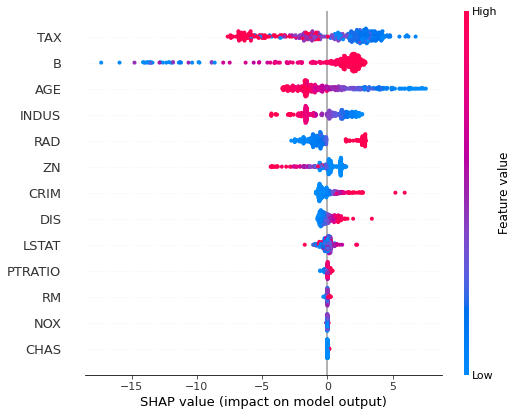

In [62]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], X_train)

*   A summary plot combines feature importance with feature effects. Each point on the summary plot is a shapely value for a feature and an instance.  
*    Feature importance: Variables are ranked in descending order.
*    Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
*    Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
*    Correlation: A high values of the B has a high and positive impact on the house price value. The “high” comes from the red color, and the "positive" impact is shown on the X-axis. Similarly, we will say “Age” is negatively correlated with the target variable.[7]


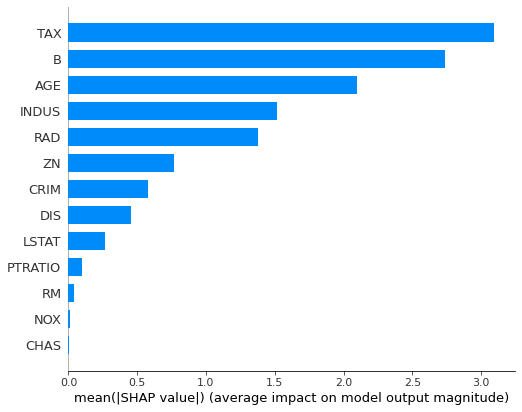

In [63]:
# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot 
# Produces stacked bars for multi-class outputs

shap.summary_plot(shap_values[0], X_train,plot_type='bar')

In [64]:
shap_expl=shap.Explanation(shap_values[0], explainer.expected_value[0],feature_names=X_train.columns)

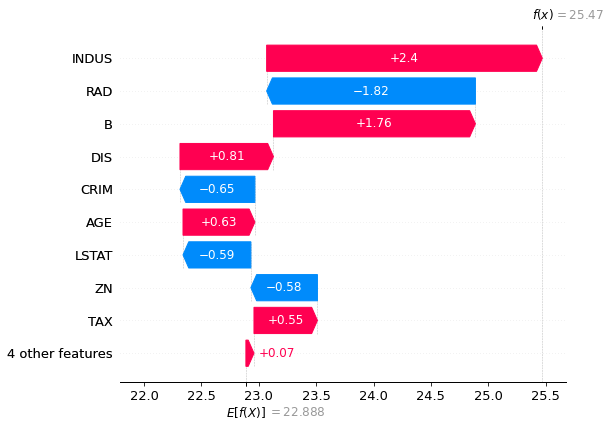

In [65]:
shap.plots.waterfall(shap_expl[0])

The SHAP waterfall plots aims to explain how individual price predictions are derived.


1.   The Y-axis encodes features and reports the values observed for observation number 0
2.   The X-axis encodes the range of our response (house prices)
1.   The E[f(X)] = 23.832 at the bottom of the chart is the result from the null model, or the global house price from our dataset

1.   The f(x) = 26.94 at the top of the chart is the model prediction for values observed in (1)

_Does the ordering of features make an impact on Shapley values?_


## **SHAP Force Plot**

_Description should be written in top-down manner, too much detail and lack of overall picture_

The force plots in the SHAP package can output both local and “global” interpretation graphs. While it does not provide a global explanation in the form of an equation like in our GLMs, it does give us a model-level view of the results to work with [15] This is done by stacking and sorting all the SHAP values for all predictions into 1 plot as shown below.

While both axes can be customized from the combo box, by default, the Y-axis shows the output value of the model, while the X-axis plots all the samples in the dataset sorted by similarity (sorting it by output value is easier to read). Hovering over an area of the graph, provides a quick summary of the significant rating factors that are driving the modelled costs up (in red) or down (in blue).

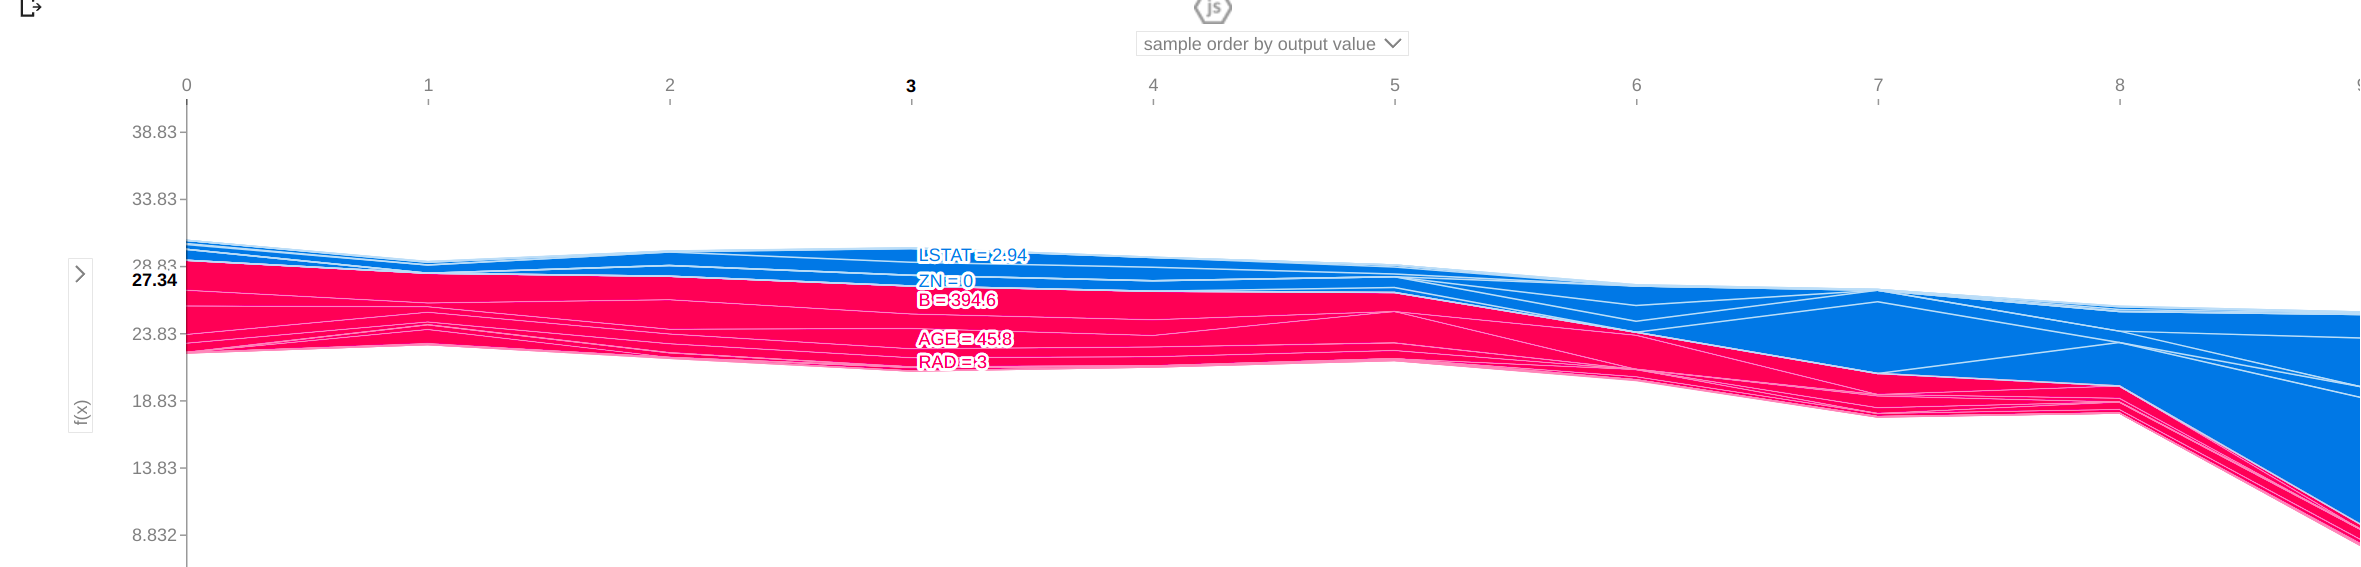

In [66]:
# Plot the SHAP values for multiple instances
shap.initjs() 
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], X_train.iloc[0:NUM_ROWS])

In [67]:
# Plot the SHAP values for one instance
shap.initjs() 
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], X_train.iloc[INSTANCE_NUM,:])

*   Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline, which for shaply values is the average of all the prediction. [7] Let's explain it in detail:
*  *The output value* is the prediction for that observation (the prediction for this observation is **26.94**).
*   *The base value*: The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat). You may wonder why it is **23.83**. This is because the mean prediction of Y_test is 23.83. 
*   *Red/blue*: In a force plot, each shapely value is displayed as an arrow that pushes the prediction to increase positive values shown here in red or decrease negative values shown here in blue. 


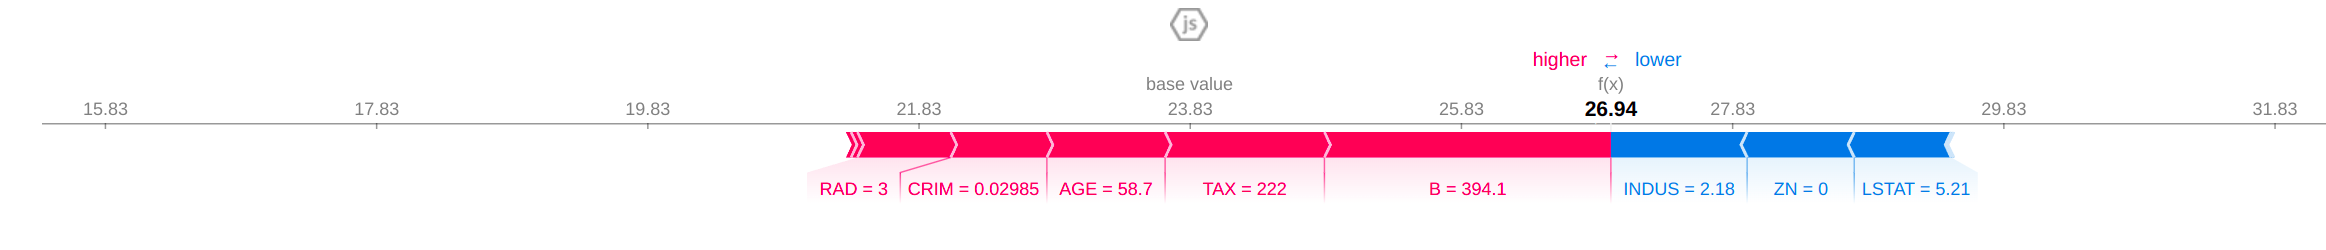

## **SHAP Dependence Plot**


A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.
*  Each dot is a single prediction (row) from the dataset.
*  The x-axis is the value of the feature (from the X matrix)
*  The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.[1]

_What does the coloring mean?_

  

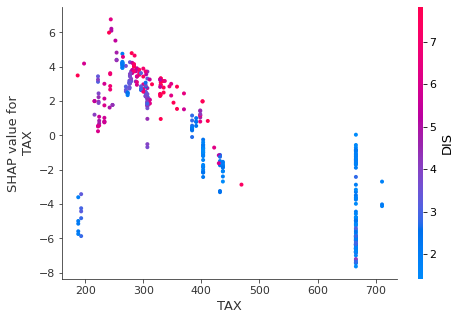

In [68]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('TAX', shap_values[0], X_train, interaction_index='DIS')

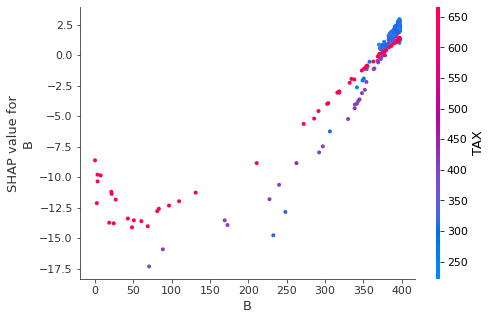

In [70]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('B', shap_values[0], X_train, interaction_index='TAX')

## **SHAP Decision Plot**

*   As like the summary plot, it gives an overall picture of contribution to prediction. From bottom to top of the decision plot, shap values are cumulatively added to the base value of the model in determining the output values.

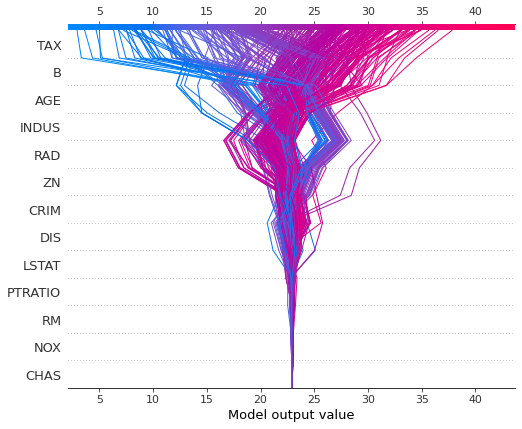

In [71]:
# decision plot for one instance
#shap_expl=shap.Explanation(shap_values[0], explainer.expected_value[0],feature_names=X_train.columns)
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=list(X_train.columns))  

# Example 2-MNIST Data Set 
## About the Dataset
* The MNIST dataset contains 60,000 training cases and 10,000 test cases of handwritten digits (0 to 9)[18]
* Each digit is normalized and centered in a gray-scale (0 - 255) image with size 28 × 28

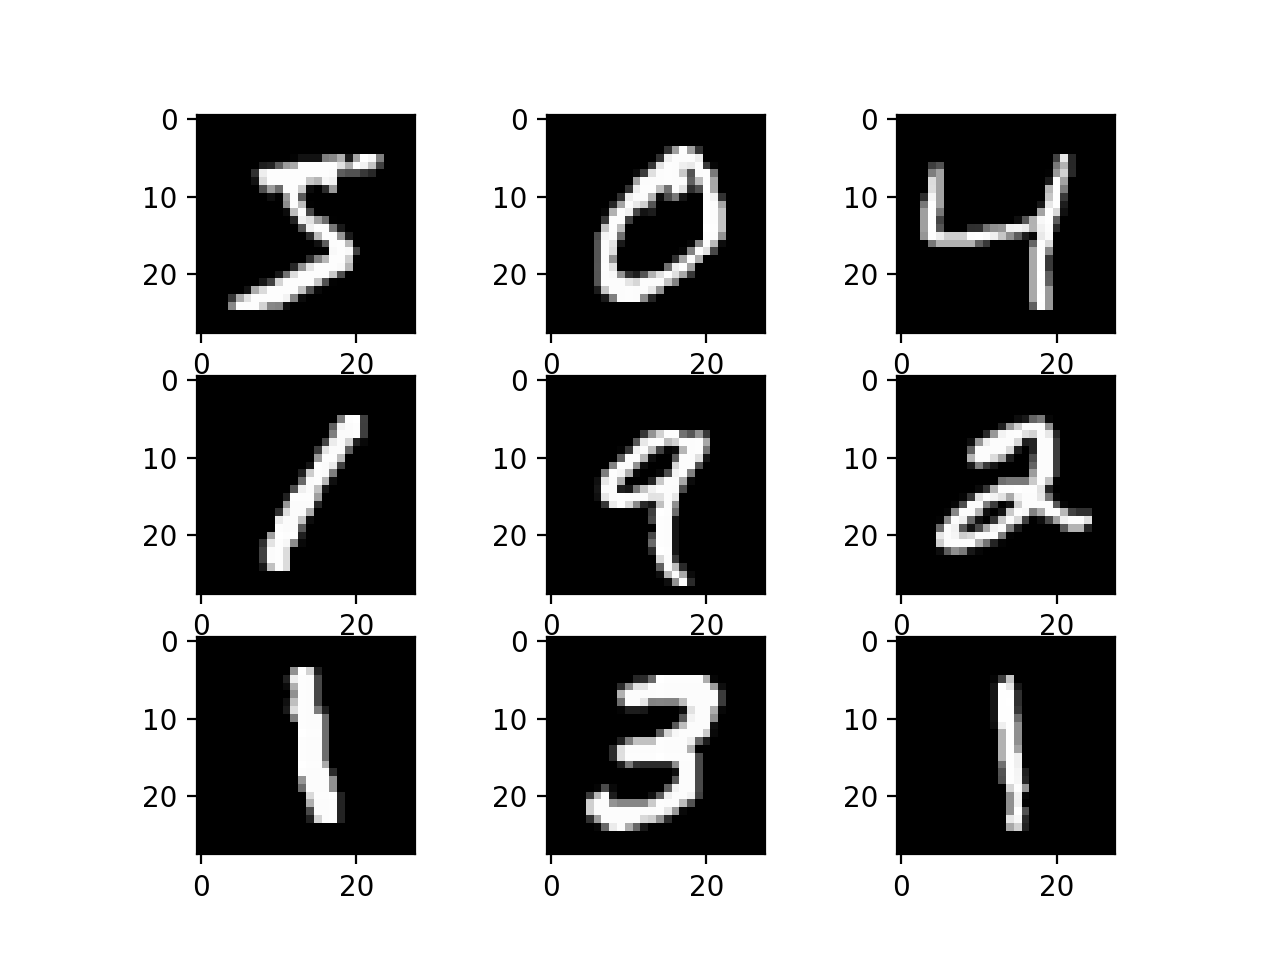

## Importing Libraries

In [72]:
import keras
from keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [73]:
batchsize = 512
total_classes = 10
epochs = 10

## Loading Data

In [74]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


##Data Preparation

In [75]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [76]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [77]:
print(X_train.shape,X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [78]:
Y_train = keras.utils.to_categorical(Y_train, total_classes)
Y_test = keras.utils.to_categorical(Y_test, total_classes)

In [79]:
print(Y_train.shape,Y_test.shape)

(60000, 10) (10000, 10)


##Model Definition

In [80]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
initial = tf.keras.Input(shape=(28, 28, 1))
X = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(initial)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)
X = layers.Dropout(0.25)(X, training=True)
X = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(X)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)
X = layers.Dropout(0.5)(X, training=True)
X = layers.Flatten()(X)
Final = layers.Dense(total_classes, activation="softmax")(X)
model = tf.keras.Model(inputs=initial, outputs=Final)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Instructions for updating:
non-resource variables are not supported in the long term
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7,

## Model Training

In [81]:
history = model.fit(X_train, Y_train, batch_size = batchsize, epochs= 10, validation_split=0.1, shuffle=True)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - ETA: 0s - loss: 0.7220 - acc: 0.7774

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


54000/54000 [==============================] - 10s 194us/sample - loss: 0.7220 - acc: 0.7774 - val_loss: 0.2248 - val_acc: 0.9340
Epoch 2/10
54000/54000 [==============================] - 3s 50us/sample - loss: 0.2106 - acc: 0.9356 - val_loss: 0.1335 - val_acc: 0.9648
Epoch 3/10
54000/54000 [==============================] - 3s 50us/sample - loss: 0.1446 - acc: 0.9559 - val_loss: 0.1029 - val_acc: 0.9715
Epoch 4/10
54000/54000 [==============================] - 3s 50us/sample - loss: 0.1173 - acc: 0.9644 - val_loss: 0.0894 - val_acc: 0.9750
Epoch 5/10
54000/54000 [==============================] - 3s 49us/sample - loss: 0.0963 - acc: 0.9699 - val_loss: 0.0785 - val_acc: 0.9777
Epoch 6/10
54000/54000 [==============================] - 3s 49us/sample - loss: 0.0842 - acc: 0.9735 - val_loss: 0.0770 - val_acc: 0.9780
Epoch 7/10
54000/54000 [==============================] - 3s 50us/sample - loss: 0.0789 - acc: 0.9758 - val_loss: 0.0703 - val_acc: 0.9785
Epoch 8/10
54000/54000 [============

In [82]:
Performance = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: ", Performance[1])
print("Test Loss: ", Performance[0])

Test Accuracy:  0.981
Test Loss:  0.05777960169371218


In [83]:
#installing shap if not installed
!pip install shap

In [84]:
import shap
#set data samples for expectation
data = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

S1 = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), data)
#calculating SHAP Values
ShapValues = S1.shap_values(X_test[1:20], check_additivity=False)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


# _What is done here? Lot of explanatory text missing_

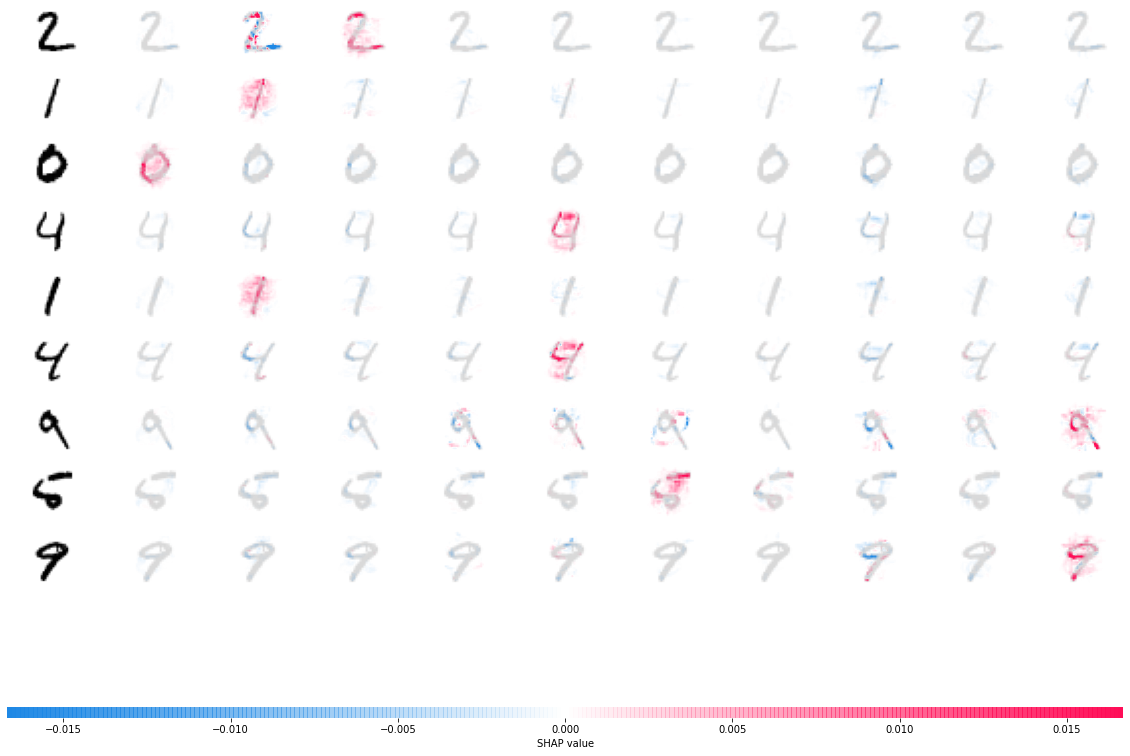

None

In [85]:
#Visualizing Feature importance
Plot = shap.image_plot(ShapValues, -X_test[1:10])
display(Plot)

###The plot above demonstrates predictions for 9 images; 2,1,0,4,1,4,9,5,4. 
* The Prediction trend is from left to right
* Red pixels refer to an improvement in output
* Blue pixels refer to a reduction in output

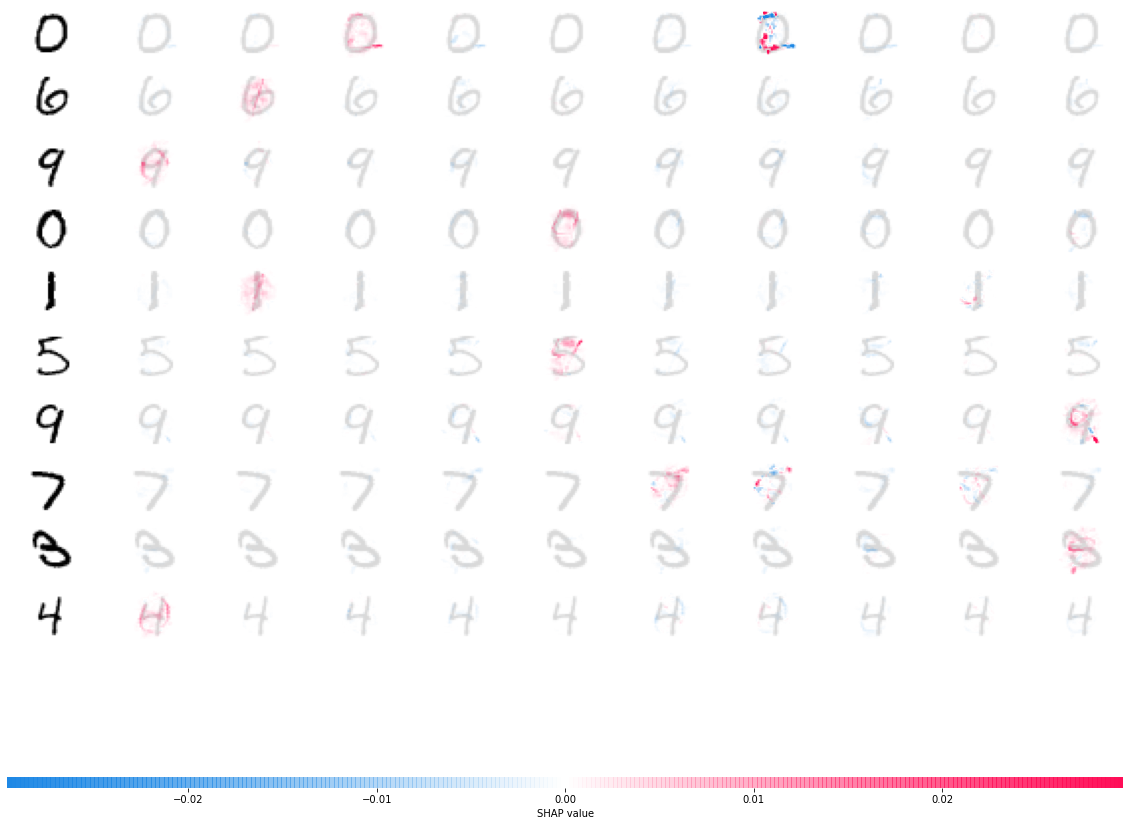

None

In [ ]:
Plot = shap.image_plot(ShapValues, -X_test[10:20])
display(Plot)

## **Conclusion**

Shapley values provide a uniform approach to decompose a model’s predictions into contributions that can be attributed additively to different explanatory variables. It is a method originally invented for assigning payouts to players depending on their contribution towards the total payout. In the explanation setting, the features are the players and the prediction is the total payout. 

An important drawback of Shapley values is that they provide additive contributions (attributions) of explanatory variables. If the model is not additive, then the Shapley values may be misleading. This issue can be seen as arising from the fact that, in cooperative games, the goal is to distribute the payoff among payers. However, in the predictive modelling context, we want to understand how do the players affect the payoff? Thus, we are not limited to independent payoff-splits for players.

_Elaborate a bit more on the last remarks_

## **References**

######  [1] Github repo: https://github.com/slundberg/shap
######  [2] A Unified Approach to Interpreting Model Predictions: https://arxiv.org/pdf/1705.07874v2.pdf
#####   [3]  https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b#5280 
######  [4] Introduction to Shapley values, https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
######  [5] https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
######  [6] Shapley Additive Explanations (SHAP) for Average Attributions: https://ema.drwhy.ai/shapley.html
######  [7] https://christophm.github.io/interpretable-ml-book/
######  [8] Aas, Kjersti et al. “Explaining individual predictions when features are dependent: More accurate approximations to Shapley values.” Artif. Intell. 298 (2021): 103502.
######  [9] https://towardsdatascience.com/pytorch-shap-explainable-convolutional-neural-networks-ece5f04c374f
######  [10] SHapley Additive exPlanations (SHAP), https://www.coursera.org/lecture/machine-learning-modeling-pipelines-in-production/shapley-additive-explanations-shap-F3NDQ
######  [11] KernelExplainer, https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
######  [12] DeepExplainer, https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html
######  [13] https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/
######  [14] KernelExplainer, https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
######  [15] https://www.actuaries.digital/2021/02/05/explainable-ml-a-peek-into-the-black-box-through-shap/
######  [16] https://shap-lrjball.readthedocs.io/en/latest/api.html#core-explainers
######  [17] Boston Housing Dataset, https://www.kaggle.com/c/house-price-prediction-with-boston-housing-dataset
######  [18] MNIST dataset, http://yann.lecun.com/exdb/mnist/
######  [19] https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

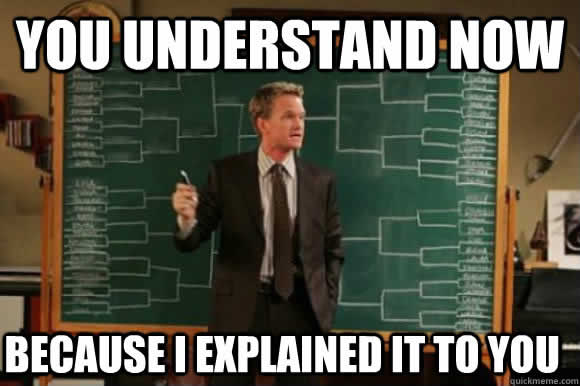